<a href="https://colab.research.google.com/github/kevin-vmi/AI-Deep-Learning-Lab-2021/blob/mednist_kevin/MedNIST_Classification_MONAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MedNIST Exam Classification with MONAI

Welcome to the RSNA2021 deep learning lab!

In this notebook, we perform a classification training with MONAI on the MedNIST dataset. Learning objectives:

* Create a MONAI Dataset to pre-process data with MONAI tranforms.
* Train a DenseNet model with MONAI and PyTorch frameworks.
* Evaluate on test dataset.

<img src='https://drive.google.com/uc?export=download&id=1ow_D-LJY6kD6n-r3x047yHbFJcDiBws3' width='500'/>

###Using Jupyter notebook:
Simply press `Shift+Enter` to run the cell. Code can be stopped by choosing in the list of "Runtime". 
 
_______________________________________________________________________________

###Part 0: Install packages and get the dataset 


In [2]:
# Install MONAI

!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     |████████████████████████████████| 699 kB 11.1 MB/s 
     |████████████████████████████████| 95.3 MB 13 kB/s 
     |████████████████████████████████| 54.5 MB 8.3 kB/s 
     |████████████████████████████████| 15.0 MB 165 kB/s 
     |████████████████████████████████| 20.3 MB 56.6 MB/s 
     |████████████████████████████████| 16.6 MB 163 kB/s 
     |████████████████████████████████| 70.6 MB 7.9 kB/s 


In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 0.8.dev2147
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 356ba3f25350e785387113684d6d2f4317a0f458

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



The MedNIST dataset was gathered from several sets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. 

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic).

In [4]:
# download the data from google drive. 
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

In [5]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()

There are 6 folders in the dataset: 

0: "Hand", 

1: "AbdomenCT",

2: "CXR",

3: "ChestCT",

4: "BreastMRI",

5: "HeadCT", 

which should be used as the labels to train our classification model.

In [6]:
os.listdir('MedNIST')

['AbdomenCT', 'CXR', 'HeadCT', 'Hand', 'BreastMRI', 'README.md', 'ChestCT']

Make sure GPU is available:

In [8]:
if torch.cuda.is_available() == False:
    print("Warning: CUDA not found, CPU only.") 
else:
    print ("GPU is connected.")      


GPU is connected.


In [9]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


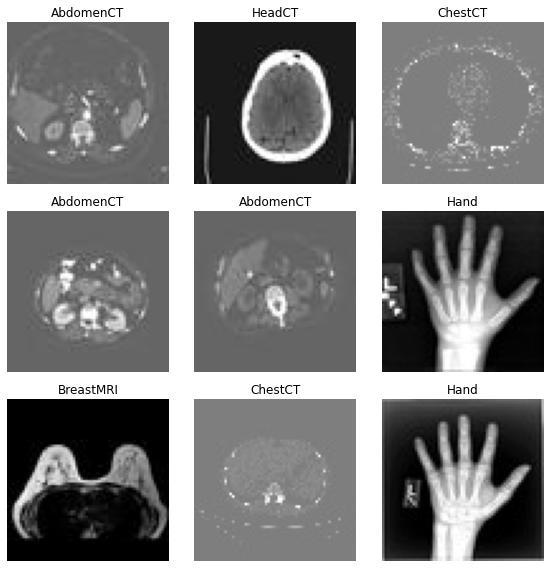

In [17]:
# Visualize some examples from the dataset
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.title(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

_______________________________________________________________________________

###Part 1: Create training, validation and test datasets, and pre-process data with MONAI. 

We move on to partioning the data into three datasets:

* Training dataset is used to minimize the loss function (80%);
* Validation dataset may be used to modify the hyperparameters (10%);
* Testing dataset is created for final evaluation once the training is completed (10%).  




In [18]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 47185 Validation count = 5834 Test count = 5935


Define MONAI transforms. (show examples, why we need to use MONAI, explain more for each augmentation operations.)

In [19]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.


Build Dataset and Dataloader (use the defined function "train_transforms" for augmentations). 

In [20]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=2)

_______________________________________________________________________________

###Part 2: Define the model and perform the training.  


In [ ]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 4
val_interval = 1

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4


Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)


1/157, train_loss: 1.8186
2/157, train_loss: 1.7886
3/157, train_loss: 1.7681
4/157, train_loss: 1.7484
5/157, train_loss: 1.7339
6/157, train_loss: 1.7011
7/157, train_loss: 1.6658
8/157, train_loss: 1.6572
9/157, train_loss: 1.6107
10/157, train_loss: 1.5882
11/157, train_loss: 1.5686
12/157, train_loss: 1.5728
13/157, train_loss: 1.5500
14/157, train_loss: 1.4986
15/157, train_loss: 1.4899
16/157, train_loss: 1.4950
17/157, train_loss: 1.4655
18/157, train_loss: 1.4356
19/157, train_loss: 1.4438
20/157, train_loss: 1.4199
21/157, train_loss: 1.4004
22/157, train_loss: 1.3958
23/157, train_loss: 1.3663
24/157, train_loss: 1.3494
25/157, train_loss: 1.2845
26/157, train_loss: 1.3246
27/157, train_loss: 1.2906
28/157, train_loss: 1.3026
29/157, train_loss: 1.2646
30/157, train_loss: 1.2141
31/157, train_loss: 1.2435
32/157, train_loss: 1.1761
33/157, train_loss: 1.2095
34/157, train_loss: 1.2139
35/157, train_loss: 1.1457
36/157, train_loss: 1.2200
37/157, train_loss: 1.1669
38/157, tr

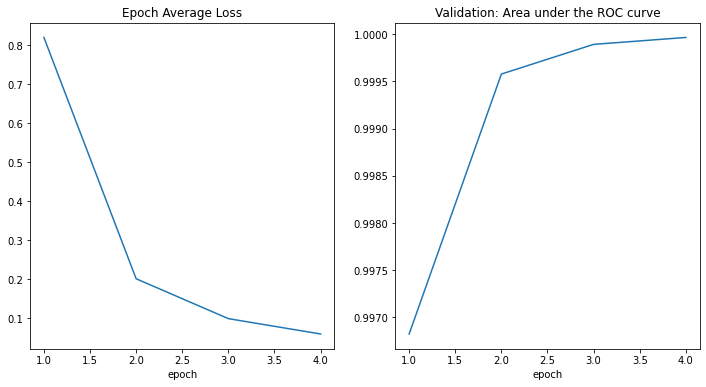

In [ ]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

_______________________________________________________________________________

###Part 3: Evaluate the best-metric model on the test dataset.  


In [ ]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9884    0.9843    0.9864       955
   BreastMRI     0.9989    0.9822    0.9905       901
         CXR     0.9980    0.9912    0.9946      1017
     ChestCT     0.9911    1.0000    0.9955      1005
        Hand     0.9902    0.9967    0.9935       915
      HeadCT     0.9880    0.9990    0.9935       992

    accuracy                         0.9924      5785
   macro avg     0.9925    0.9922    0.9923      5785
weighted avg     0.9924    0.9924    0.9924      5785

